<span style="font-size: 20px;">**Data Source**</span>

In [169]:
import json
from datetime import datetime, timedelta, timezone
from dateutil.parser import isoparse

with open("watch-history.json", "r") as file:
    file_content = file.read()

content = json.loads(file_content)

<span style="font-size: 20px;">**Filter the Shorts**</span>

In [170]:
titles = []
unique_titles = set()

one_year_ago = datetime.now(timezone.utc) - timedelta(days=365)
filter_words = ["short", "#", "https"]
last_date = None

In [171]:

for watched in content:
    title = watched["title"].removeprefix("Watched ")
    date_string = watched["time"]
    parsed_date = isoparse(date_string)
    if last_date is not None:
        if last_date - parsed_date < timedelta(minutes=1):
            continue

    last_date = parsed_date

    # contains emoji
    if any(ord(char) > 127 for char in title):
        continue
    if any(word in title.lower() for word in filter_words):
        continue

    if parsed_date < one_year_ago:
        continue
    if "\n" in title:
        title = title.split("\n")[0]

    titles.append(title)
    unique_titles.add(title)

<span style="font-size: 20px;">**Exploratory Data Analysis**</span>

In [172]:
import json
from datetime import datetime, timedelta, timezone
from dateutil.parser import isoparse
import pandas as pd

# Load the watch history JSON file
with open("watch-history.json", "r") as file:
    file_content = file.read()

content = json.loads(file_content)

# Initialize the list to store video information
video_data = []

# Set filters and time constraints
one_year_ago = datetime.now(timezone.utc) - timedelta(days=365)
filter_words = ["short", "#", "https"]
last_date = None

# Define time of day categories
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return "Morning"
    elif 6 <= hour < 12:
        return "Noon"
    elif 12 <= hour < 18:
        return "Evening"
    else:
        return "Night"

# Traverse the JSON content
for watched in content:
    title = watched["title"].removeprefix("Watched ")
    date_string = watched["time"]
    parsed_date = isoparse(date_string)
    
    # Skip videos watched within 1 minute of the previous entry
    if last_date is not None and (last_date - parsed_date) < timedelta(minutes=1):
        continue

    last_date = parsed_date

    # Skip videos with emojis or filter words
    if any(ord(char) > 127 for char in title):
        continue
    if any(word in title.lower() for word in filter_words):
        continue

    # Skip videos older than one year
    if parsed_date < one_year_ago:
        continue

    # Extract channel name if available
    channel_name = watched.get("subtitles", [{}])[0].get("name", "Unknown Channel")

    # Determine time of day
    time_of_day = get_time_of_day(parsed_date.hour)

    # Determine day of the week
    day_of_week = parsed_date.strftime("%A")

    # Determine the week number relative to the past year (oldest week = 1, most recent = 52)
    week_number = ((datetime.now(timezone.utc) - parsed_date).days // 7) + 1

    # Determine the month
    month = parsed_date.strftime("%B")


    # Store the data
    video_data.append({
        "Video Title": title,
        "Channel Name": channel_name,
        "Date Watched": parsed_date.strftime("%Y-%m-%d"),
        "Time of Day": time_of_day,
        "Day of Week": day_of_week,
        "Week Number": week_number,
        "Month": month
    })

# Convert the data into a DataFrame
video_data_df = pd.DataFrame(video_data)

# Display the DataFrame
print(video_data_df.head())

                                         Video Title      Channel Name  \
0  Which Marvel Rivals Strategist Has The Best Ul...          Pitless    
1           Baking vs Frying vs Steaming Bread Dough  benjaminthebaker   
2   2025 Porsche Spyder RS Review // We Are Now Deaf    Throttle House   
3           I Got Matched With ZBRA in Marvel Rivals         More Jay3   
4  ImDOntai Reacts To Invisible Woman Marvel Riva...     ImStillDontai   

  Date Watched Time of Day Day of Week  Week Number    Month  
0   2025-01-09        Noon    Thursday            1  January  
1   2025-01-09        Noon    Thursday            1  January  
2   2025-01-09        Noon    Thursday            1  January  
3   2025-01-09     Morning    Thursday            1  January  
4   2025-01-08       Night   Wednesday            1  January  


<span style="font-size: 20px;">**Categorize videos based on manually categorized data**</span>

In [173]:
import pandas as pd

# Load the categorization Excel file
categories_file_path = "categories.xlsx"  # Ensure this is the correct path to the Excel file
channel_categories = pd.read_excel(categories_file_path)

# Create a dictionary from the Excel file for faster lookup
channel_category_dict = channel_categories.set_index('Channel Name')['Category'].to_dict()

# Add a "Category" column to the DataFrame based on the channel categorization
video_data_df['Category'] = video_data_df['Channel Name'].map(channel_category_dict)

# Display the updated DataFrame with the "Category" column
print(video_data_df.head())

                                         Video Title      Channel Name  \
0  Which Marvel Rivals Strategist Has The Best Ul...          Pitless    
1           Baking vs Frying vs Steaming Bread Dough  benjaminthebaker   
2   2025 Porsche Spyder RS Review // We Are Now Deaf    Throttle House   
3           I Got Matched With ZBRA in Marvel Rivals         More Jay3   
4  ImDOntai Reacts To Invisible Woman Marvel Riva...     ImStillDontai   

  Date Watched Time of Day Day of Week  Week Number    Month    Category  
0   2025-01-09        Noon    Thursday            1  January         NaN  
1   2025-01-09        Noon    Thursday            1  January    Culinary  
2   2025-01-09        Noon    Thursday            1  January  Automotive  
3   2025-01-09     Morning    Thursday            1  January         NaN  
4   2025-01-08       Night   Wednesday            1  January       Music  


<span style="font-size: 20px;">**Use a ML model to categorize the uncategorized data**</span>

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd

# Filter rows with non-NaN categories
labeled_data = video_data_df.dropna(subset=['Category'])

# Features and labels
X = labeled_data['Video Title']
y = labeled_data['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a pipeline with TF-IDF vectorization and a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),  # Convert text to TF-IDF features
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))   # Random Forest Classifier
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)

# Get the classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Add a "Total Videos in DataFrame" column to the report
category_counts = labeled_data['Category'].value_counts()
total_videos = len(labeled_data)  # Total number of videos in the dataframe
for category in report.keys():
    if isinstance(report[category], dict):  # Ensure it's a dictionary for categories
        report[category]["total_videos"] = category_counts.get(category, 0)
        report[category]["percentage"] = (category_counts.get(category, 0) / total_videos) * 100  # Calculate percentage

# Convert the report dictionary to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Save all videos (including their attributes) into the categorized_df
categorized_df = video_data_df.copy()  # Copy the original dataframe to retain all attributes
categorized_df['Predicted Category'] = pipeline.predict(video_data_df['Video Title'])  # Predict and add the category

# Display the updated categorized DataFrame
print(categorized_df.head())

# Print the detailed classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

                                         Video Title      Channel Name  \
0  Which Marvel Rivals Strategist Has The Best Ul...          Pitless    
1           Baking vs Frying vs Steaming Bread Dough  benjaminthebaker   
2   2025 Porsche Spyder RS Review // We Are Now Deaf    Throttle House   
3           I Got Matched With ZBRA in Marvel Rivals         More Jay3   
4  ImDOntai Reacts To Invisible Woman Marvel Riva...     ImStillDontai   

  Date Watched Time of Day Day of Week  Week Number    Month    Category  \
0   2025-01-09        Noon    Thursday            1  January         NaN   
1   2025-01-09        Noon    Thursday            1  January    Culinary   
2   2025-01-09        Noon    Thursday            1  January  Automotive   
3   2025-01-09     Morning    Thursday            1  January         NaN   
4   2025-01-08       Night   Wednesday            1  January       Music   

  Predicted Category  
0                MMA  
1           Culinary  
2         Automotive  
3     

<span style="font-size: 20px;">**Filter for Shorts again after categorization**</span>

In [175]:
# Remove "Shorts" row from dataframe
categorized_df = categorized_df[categorized_df.index != 'Shorts'].copy()

print(f"Shape of categorized dataframe after removing 'Shorts': {categorized_df.shape}")

print(categorized_df.head())

Shape of categorized dataframe after removing 'Shorts': (6536, 9)
                                         Video Title      Channel Name  \
0  Which Marvel Rivals Strategist Has The Best Ul...          Pitless    
1           Baking vs Frying vs Steaming Bread Dough  benjaminthebaker   
2   2025 Porsche Spyder RS Review // We Are Now Deaf    Throttle House   
3           I Got Matched With ZBRA in Marvel Rivals         More Jay3   
4  ImDOntai Reacts To Invisible Woman Marvel Riva...     ImStillDontai   

  Date Watched Time of Day Day of Week  Week Number    Month    Category  \
0   2025-01-09        Noon    Thursday            1  January         NaN   
1   2025-01-09        Noon    Thursday            1  January    Culinary   
2   2025-01-09        Noon    Thursday            1  January  Automotive   
3   2025-01-09     Morning    Thursday            1  January         NaN   
4   2025-01-08       Night   Wednesday            1  January       Music   

  Predicted Category  
0        

<span style="font-size: 20px;">**Define exam weeks and datas' distance to exam dates**</span>

In [176]:
import pandas as pd

# List of exam week dates
exam_week_dates = [
    "2024-03-13", "2024-03-24", "2024-04-07", "2024-04-27", "2024-05-05",
    "2024-05-11", "2024-05-29", "2024-06-07", "2024-06-09", "2024-11-02",
    "2024-11-03", "2024-11-04", "2024-11-07", "2024-11-10", "2024-11-24",
    "2024-12-01", "2024-12-12", "2024-12-14", "2025-01-02", "2025-01-03",
    "2025-01-04", "2025-01-05", "2025-01-07", "2025-01-12"
]

# Ensure your DataFrame is named `categorized_df`
# Add a 'week' column based on the watched date
categorized_df['week'] = pd.to_datetime(categorized_df['Date Watched']).dt.to_period('W')

# Convert exam dates to pandas Periods (week-based)
exam_weeks = [pd.to_datetime(date).to_period('W') for date in exam_week_dates]

# Calculate the maximum distance for normalization
max_dist = max(
    categorized_df['week'].apply(
        lambda x: min(abs((x.start_time - exam_week.start_time).days) for exam_week in exam_weeks)
    )
)

# Calculate the normalized distances and round to 2 decimals
categorized_df['dist_from_exam_week'] = categorized_df['week'].apply(
    lambda x: 0.0 if x in exam_weeks else 
    round(min(abs((x.start_time - exam_week.start_time).days) for exam_week in exam_weeks) / max_dist, 2)
)

# Drop the temporary 'week' column if not needed
categorized_df.drop(columns=['week'], inplace=True)

# Display the updated DataFrame
print(categorized_df.head())

                                         Video Title      Channel Name  \
0  Which Marvel Rivals Strategist Has The Best Ul...          Pitless    
1           Baking vs Frying vs Steaming Bread Dough  benjaminthebaker   
2   2025 Porsche Spyder RS Review // We Are Now Deaf    Throttle House   
3           I Got Matched With ZBRA in Marvel Rivals         More Jay3   
4  ImDOntai Reacts To Invisible Woman Marvel Riva...     ImStillDontai   

  Date Watched Time of Day Day of Week  Week Number    Month    Category  \
0   2025-01-09        Noon    Thursday            1  January         NaN   
1   2025-01-09        Noon    Thursday            1  January    Culinary   
2   2025-01-09        Noon    Thursday            1  January  Automotive   
3   2025-01-09     Morning    Thursday            1  January         NaN   
4   2025-01-08       Night   Wednesday            1  January       Music   

  Predicted Category  dist_from_exam_week  
0                MMA                  0.0  
1         

In [177]:
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

if 'time_of_day' not in categorized_df.columns:
    categorized_df['time_of_day'] = pd.to_datetime(categorized_df['Date Watched']).dt.hour.apply(assign_time_of_day)


<span style="font-size: 20px;">**Visualization**</span>

<span style="font-size: 18px;">How the number of videos I watched changes based on the dates distance to an exam week</span>

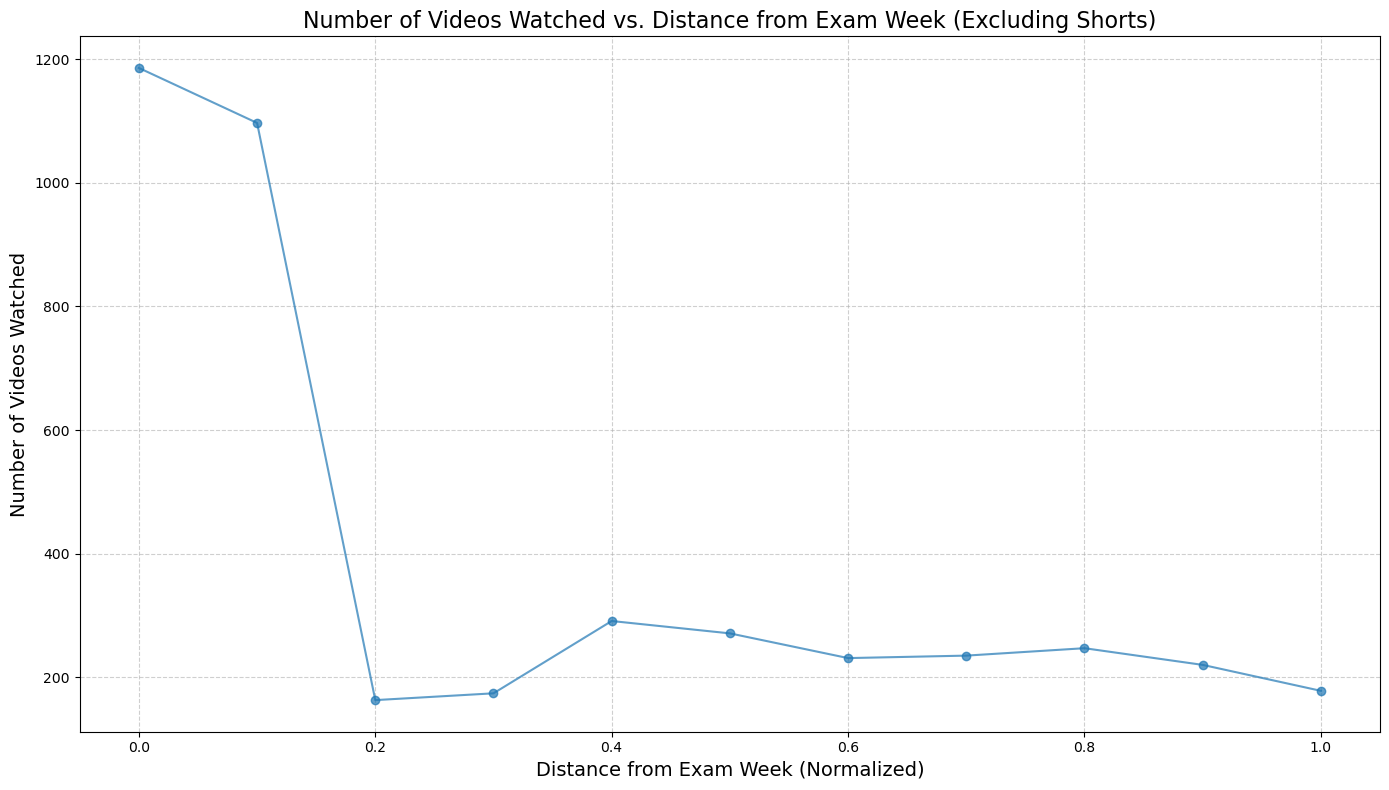

In [178]:
import matplotlib.pyplot as plt

# Filter out rows where 'Predicted Category' is NaN or "Shorts"
filtered_df = categorized_df[
    (categorized_df['Predicted Category'] != 'Shorts')
]

# Group data to calculate the number of videos watched at each distance from the exam week
grouped_data = filtered_df.groupby('dist_from_exam_week').size().reset_index(name='Videos Watched')

# Line Chart for 'dist_from_exam_week' vs 'Videos Watched'
plt.figure(figsize=(14, 8))
plt.plot(
    grouped_data['dist_from_exam_week'],
    grouped_data['Videos Watched'],
    marker='o',
    linestyle='-',
    alpha=0.7
)
plt.title('Number of Videos Watched vs. Distance from Exam Week (Excluding Shorts)', fontsize=16)
plt.xlabel('Distance from Exam Week (Normalized)', fontsize=14)
plt.ylabel('Number of Videos Watched', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<span style="font-size: 18px;">Categorical representation</span>

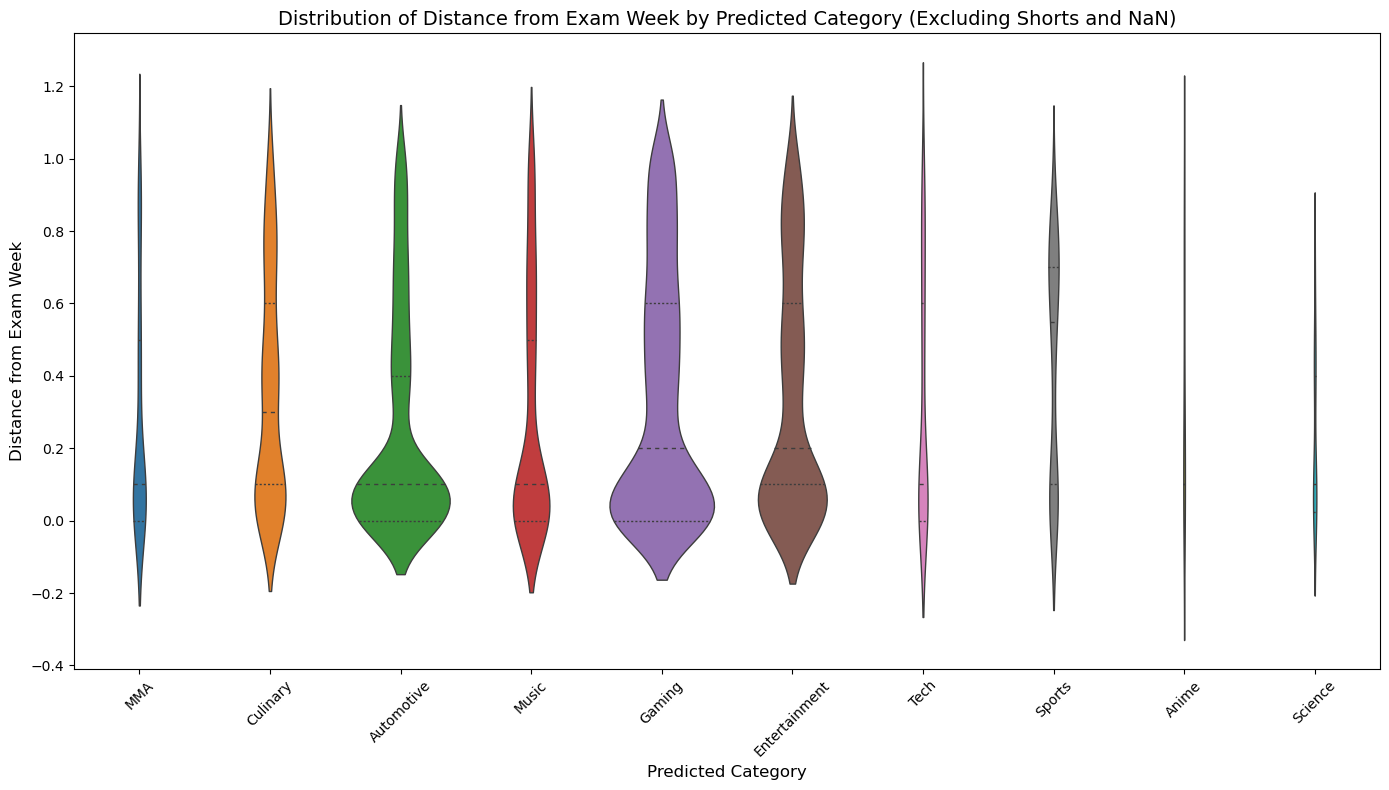

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot using the 'Predicted Category'
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='Predicted Category',
    y='dist_from_exam_week',
    data=filtered_df,
    scale='count',  # Scale violins by the count of data points
    inner='quartile',  # Show quartiles within the violins
    linewidth=1
)

# Add labels and title
plt.title('Distribution of Distance from Exam Week by Predicted Category (Excluding Shorts and NaN)', fontsize=14)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Distance from Exam Week', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

<span style="font-size: 18px;">Create another attribute to indicate weekend or not</span>

In [180]:
# Define a function to categorize the data based on the day of the week and time of day
def categorize_weekday_weekend(row):
    day = row['Day of Week']
    time = row['time_of_day']

    # Check conditions for weekends and weekdays
    if (day == 'Saturday' and time == 'Night') or (day == 'Friday' and time == 'Evening'):
        return 0  # Special weekend night cases
    elif day in ['Saturday', 'Sunday']:
        return 1  # Weekend for remaining time periods
    else:
        return -1  # Remaining weekdays

# Apply the function to create a new column using loc
filtered_df.loc[:, 'weekend_or_weekday'] = filtered_df.apply(categorize_weekday_weekend, axis=1)

# Display the updated DataFrame
print(filtered_df[['Day of Week', 'time_of_day', 'weekend_or_weekday']].head())

  Day of Week time_of_day  weekend_or_weekday
0    Thursday       Night                  -1
1    Thursday       Night                  -1
2    Thursday       Night                  -1
3    Thursday       Night                  -1
4   Wednesday       Night                  -1


/var/folders/rx/q6kf9dg909s0kk0602zp39600000gn/T/ipykernel_86078/2554077723.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'weekend_or_weekday'] = filtered_df.apply(categorize_weekday_weekend, axis=1)


<span style="font-size: 18px;">Create a heatmap</span>

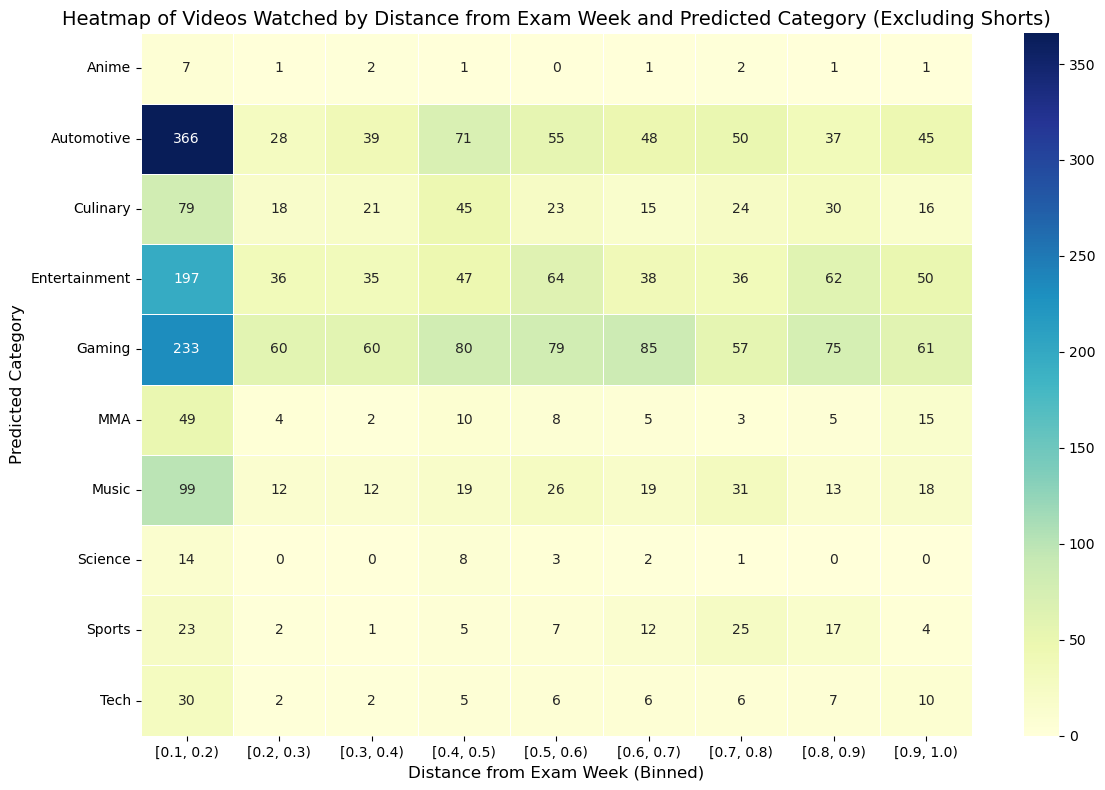

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter out rows where 'Predicted Category' is "Shorts" or NaN and where 'dist_from_exam_week' is less than 0.1
heatmap_df = filtered_df[
    (filtered_df['dist_from_exam_week'] >= 0.1)
].copy()  # Use `.copy()` to avoid SettingWithCopyWarning

# Bin the 'dist_from_exam_week' column into equal ranges starting from 0.1
bins = [i / 10 for i in range(1, 11)]  # Creates bins [0.1, 0.2, ..., 1.0]
labels = [f"[{round(bins[i], 1)}, {round(bins[i + 1], 1)})" for i in range(len(bins) - 1)]
heatmap_df['dist_bin'] = pd.cut(heatmap_df['dist_from_exam_week'], bins=bins, labels=labels, include_lowest=True, right=False)

# Create a pivot table for heatmap data
heatmap_data = heatmap_df.pivot_table(
    index='Predicted Category',
    columns='dist_bin',
    values='Video Title',  # Use 'Video Title' as a proxy for video counts
    aggfunc='count',
    fill_value=0
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5
)
plt.title('Heatmap of Videos Watched by Distance from Exam Week and Predicted Category (Excluding Shorts)', fontsize=14)
plt.xlabel('Distance from Exam Week (Binned)', fontsize=12)
plt.ylabel('Predicted Category', fontsize=12)
plt.tight_layout()
plt.show()

<span style="font-size: 18px;">Calculate correlation</span>

In [182]:
from scipy.stats import pearsonr
import pandas as pd

# Filter out rows where 'Category' is 'Shorts' or where 'dist_from_exam_week' is 0.0
p_correlation_df = filtered_df[
    (filtered_df['dist_from_exam_week'] != 0.0)
]

# Aggregate data: count the number of videos watched per unique 'dist_from_exam_week'
aggregated_data = p_correlation_df.groupby('dist_from_exam_week').size().reset_index(name='Videos Watched')

# Compute Pearson correlation
correlation_coefficient, p_value = pearsonr(aggregated_data['dist_from_exam_week'], aggregated_data['Videos Watched'])

# Display results
print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant correlation between 'dist_from_exam_week' and 'Videos Watched'.")
else:
    print("No statistically significant correlation was found.")

Pearson Correlation Coefficient: -0.5066299530415291
P-Value: 0.13507582573975413
No statistically significant correlation was found.


In [183]:
from scipy.stats import spearmanr
import pandas as pd

# Filter out rows where 'Category' is 'Shorts' or where 'dist_from_exam_week' is 0.0
s_correlation_df = filtered_df[
    (filtered_df['dist_from_exam_week'] != 0.0)
]

# Aggregate data: count the number of videos watched per unique 'dist_from_exam_week'
aggregated_data = s_correlation_df.groupby('dist_from_exam_week').size().reset_index(name='Videos Watched')

# Compute Spearman correlation
spearman_coefficient, p_value = spearmanr(aggregated_data['dist_from_exam_week'], aggregated_data['Videos Watched'])

# Display results
print("Spearman Correlation Coefficient:", spearman_coefficient)
print("P-Value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant monotonic correlation between 'dist_from_exam_week' and 'Videos Watched'.")
else:
    print("No statistically significant monotonic correlation was found.")

Spearman Correlation Coefficient: -0.17575757575757575
P-Value: 0.6271883447764844
No statistically significant monotonic correlation was found.


<span style="font-size: 20px;">**Machine Learning**</span>

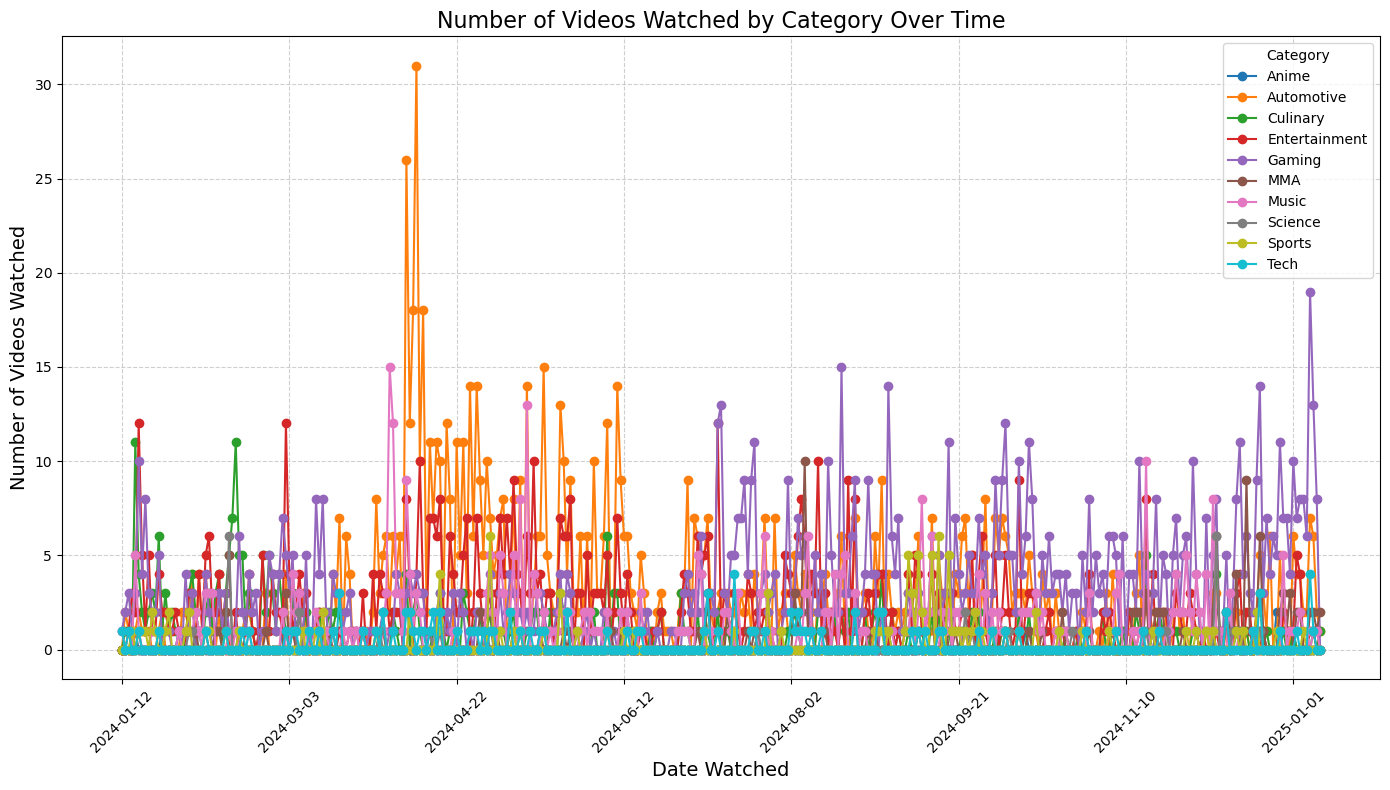

In [184]:
import matplotlib.pyplot as plt

# Group data by date and category
line_data = filtered_df.groupby(['Date Watched', 'Predicted Category']).size().reset_index(name='Videos Watched')

# Pivot the data for plotting
line_data_pivot = line_data.pivot(index='Date Watched', columns='Predicted Category', values='Videos Watched').fillna(0)

# Create the line chart
plt.figure(figsize=(14, 8))
line_data_pivot.plot(ax=plt.gca(), marker='o', linestyle='-')

# Add labels and title
plt.title('Number of Videos Watched by Category Over Time', fontsize=16)
plt.xlabel('Date Watched', fontsize=14)
plt.ylabel('Number of Videos Watched', fontsize=14)
plt.legend(title='Category', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

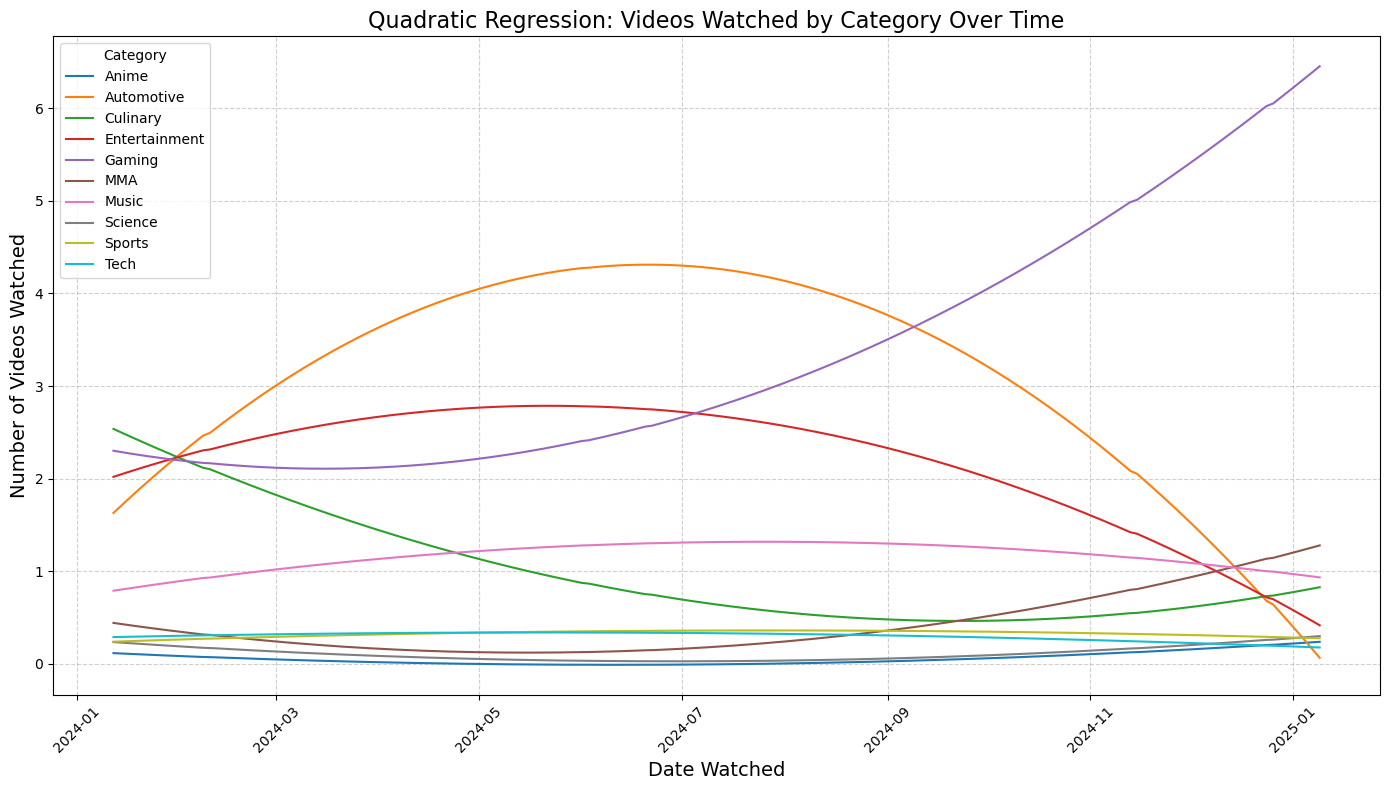

In [185]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create a copy of the filtered DataFrame
filtered_df = filtered_df.copy()

# Ensure 'Date Watched' is in datetime format
filtered_df['Date Watched'] = pd.to_datetime(filtered_df['Date Watched'])

# Group data by date and category
line_data = filtered_df.groupby(['Date Watched', 'Predicted Category']).size().reset_index(name='Videos Watched')

# Pivot the data for regression
line_data_pivot = line_data.pivot(index='Date Watched', columns='Predicted Category', values='Videos Watched').fillna(0)

# Sort the index to ensure proper chronological order
line_data_pivot = line_data_pivot.sort_index()

# Prepare data for plotting
dates = np.arange(len(line_data_pivot.index))  # Numerical representation of dates
plt.figure(figsize=(14, 8))

# Iterate over each category to apply regression
for category in line_data_pivot.columns:
    # Extract the data for the current category
    y = line_data_pivot[category].values
    x = dates.reshape(-1, 1)
    
    # Fit a quadratic regression model
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Plot the regression line
    plt.plot(line_data_pivot.index, y_pred, label=category)

# Add labels and title
plt.title('Quadratic Regression: Videos Watched by Category Over Time', fontsize=16)
plt.xlabel('Date Watched', fontsize=14)
plt.ylabel('Number of Videos Watched', fontsize=14)
plt.legend(title='Category', fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [186]:
import pandas as pd

# Assuming 'Date Watched' and 'weekend_or_weekday' are in the dataframe
# Add a column to count each video (if not already present)
filtered_df['video_count'] = 1

# Group data by 'weekend_or_weekday' and 'Date Watched' to count videos watched per day
daily_counts = filtered_df.groupby(['weekend_or_weekday', 'Date Watched'])['video_count'].sum().reset_index()

# Calculate the mean videos watched per day for each `weekend_or_weekday`
average_videos_by_type = daily_counts.groupby('weekend_or_weekday')['video_count'].mean().reset_index()

# Rename columns for clarity
average_videos_by_type.columns = ['Weekend or Weekday (-1, 0, 1)', 'Average Videos Watched']

# Print the result
print(average_videos_by_type)

   Weekend or Weekday (-1, 0, 1)  Average Videos Watched
0                             -1               11.824219
1                              0               11.807692
2                              1               12.784314


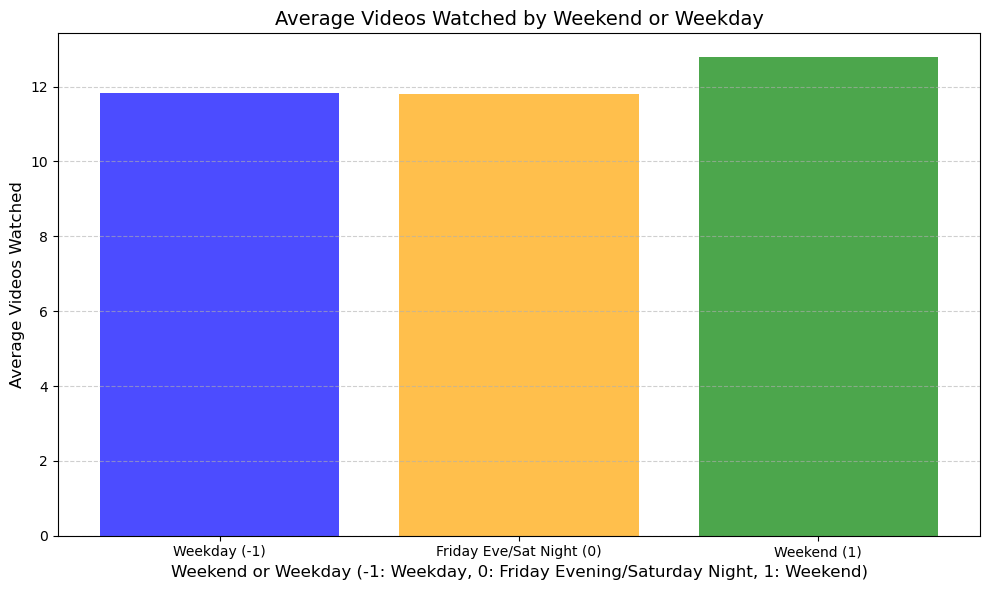

In [187]:
import matplotlib.pyplot as plt

# Bar chart to visualize average videos watched by weekend/weekday type
plt.figure(figsize=(10, 6))
plt.bar(
    average_videos_by_type['Weekend or Weekday (-1, 0, 1)'],
    average_videos_by_type['Average Videos Watched'],
    color=['blue', 'orange', 'green'],
    alpha=0.7
)

# Add labels, title, and ticks
plt.title('Average Videos Watched by Weekend or Weekday', fontsize=14)
plt.xlabel('Weekend or Weekday (-1: Weekday, 0: Friday Evening/Saturday Night, 1: Weekend)', fontsize=12)
plt.ylabel('Average Videos Watched', fontsize=12)
plt.xticks(average_videos_by_type['Weekend or Weekday (-1, 0, 1)'], ['Weekday (-1)', 'Friday Eve/Sat Night (0)', 'Weekend (1)'])

# Add a grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tight layout for proper spacing
plt.tight_layout()

# Show the plot
plt.show()